In [90]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets, transforms, models
from PIL import Image
import csv

In [2]:
torch.__version__

'2.5.1+cu121'

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
import requests
import zipfile
import pathlib
from pathlib import Path
try:
  import py7zr
except :
  !pip install py7zr
  import py7zr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 38.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.3/93.3 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.0/139.0 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.7/413.7 kB 26.1 MB/s eta 0:00:00


In [6]:
image_path = Path("/kaggle/working/cifar10")
if image_path.exists():
  print(f"{image_path} already exists")
else:
  image_path.mkdir(parents=True, exist_ok=True)
  print(f"creating {image_path}...")

creating /kaggle/working/cifar10...


In [7]:
train_path = image_path/"train"
test_path = image_path/"test"

In [8]:
with py7zr.SevenZipFile("/kaggle/input/cifar-10/train.7z", mode='r') as train_images:
    train_images.extractall(image_path)
with py7zr.SevenZipFile("/kaggle/input/cifar-10/test.7z", mode='r') as test_images:
    test_images.extractall(image_path) 

In [9]:
import os
def explore_directoris(path):
  for dirpath, dirnames,filenames in os.walk(path):
    print(f"there are {len(dirnames)} directoris and {len(filenames)} files in {dirpath}")
explore_directoris(image_path)

there are 2 directoris and 0 files in /kaggle/working/cifar10
there are 0 directoris and 50000 files in /kaggle/working/cifar10/train
there are 0 directoris and 300000 files in /kaggle/working/cifar10/test


In [11]:
class customImageFolder(Dataset):
  def __init__(self, root, transform=None,mode="train"):
    self.paths = list(pathlib.Path(root).glob("*.png"))
    self.transform = transform
    self.mode = mode
    if self.mode=="train":
      self.labels = {}
      file_path = "/kaggle/input/cifar-10/trainLabels.csv"
      with open(file_path, mode='r') as file:
          csv_reader = csv.DictReader(file)
          for row in csv_reader:
              self.labels[int(row['id'])] = row['label']
      self.classes = sorted(list(set(self.labels.values())))
      self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

  def load_image(self, index):
    image_path = self.paths[index]
    image = Image.open(image_path)
    image = image.convert("RGB")
    return image

  def __len__(self):
    return len(self.paths)

  def __getitem__(self, index):
    image = self.load_image(index)
    if self.mode == "train":
      class_name = self.labels[int(os.path.splitext(os.path.basename(self.paths[index]))[0])]
      class_idx = self.class_to_idx[class_name]
      if self.transform:
        image = self.transform(image)
      return image, class_idx

    else:
      if self.transform:
          image = self.transform(image)
      return image

In [76]:
# Data Augmentation and Normalization
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.RandomHorizontalFlip(),  
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


In [77]:
data = customImageFolder(train_path, transform=data_transform)

In [78]:
data[0][0].shape

torch.Size([3, 224, 224])

In [79]:
import random
import matplotlib.pyplot as plt
import math
def display_random_images(dataset,classes,n,seed=None):
  if n>10:
    n=10
  if seed:
    torch.manual_seed(seed)
  random_samples_idx = random.sample(range(len(dataset.paths)),n)
  plt.figure(figsize=(16,8))
  for i, id in enumerate(random_samples_idx):
    image, label = dataset[id]
    plt.subplot(1,n,i+1)
    plt.imshow(image.permute(1,2,0))
    plt.axis("off")
    title = f"class : {classes[label]} | \n size : {image.permute(1,2,0).shape}"
    plt.title(title,fontdict={'fontsize':8})


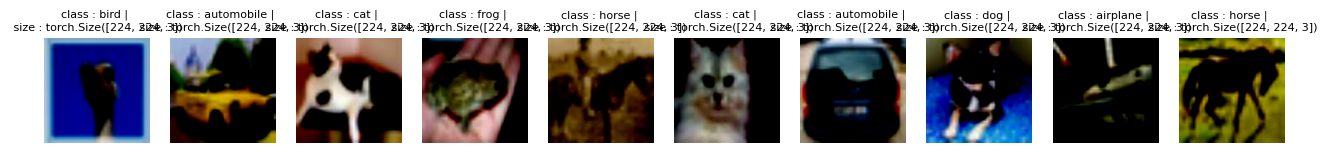

In [80]:
display_random_images(data,data.classes,10,seed=42)

In [81]:
from torch.utils.data import random_split
train_size = int(0.8 * len(data))
test_size = len(data) - train_size

train_data, test_data = random_split(data, [train_size, test_size])

In [82]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data, # use custom created train Dataset
                                     batch_size=64, # how many samples per batch?
                                     num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data, # use custom created test Dataset
                                    batch_size=64,
                                    num_workers=0,
                                    shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7c7c1720f760>,
 <torch.utils.data.dataloader.DataLoader at 0x7c7c1720f520>)

In [84]:
model_ = models.vgg16(pretrained=True)

# Freeze Convolutional Base
for param in model_.features.parameters():
    param.requires_grad = False

# Modify the classifier for CIFAR-10 (10 classes)
model_.classifier = nn.Sequential(
    nn.Linear(25088, 4096),  # Input features = 25088 (from VGG-16 feature extractor)
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(4096, len(data.classes))  # Output classes = 10 (CIFAR-10)
)

In [85]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo
from torchinfo import summary
summary(model_,input_size=(64,3,64,64))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [64, 10]                  --
├─Sequential: 1-1                        [64, 512, 2, 2]           --
│    └─Conv2d: 2-1                       [64, 64, 64, 64]          (1,792)
│    └─ReLU: 2-2                         [64, 64, 64, 64]          --
│    └─Conv2d: 2-3                       [64, 64, 64, 64]          (36,928)
│    └─ReLU: 2-4                         [64, 64, 64, 64]          --
│    └─MaxPool2d: 2-5                    [64, 64, 32, 32]          --
│    └─Conv2d: 2-6                       [64, 128, 32, 32]         (73,856)
│    └─ReLU: 2-7                         [64, 128, 32, 32]         --
│    └─Conv2d: 2-8                       [64, 128, 32, 32]         (147,584)
│    └─ReLU: 2-9                         [64, 128, 32, 32]         --
│    └─MaxPool2d: 2-10                   [64, 128, 16, 16]         --
│    └─Conv2d: 2-11                      [64, 256, 16, 16]   

In [86]:

def train_step(model, data_loader, loss_fn, optimizer, device):
    model.train()
    train_loss, train_acc = 0.0, 0.0  # Use floats for better precision

    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)

        # Forward pass
        y_pred = model(X)
        loss = loss_fn(y_pred, y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute metrics
        train_loss += loss.item()  # Convert loss tensor to scalar
        y_pred_class = torch.argmax(y_pred, dim=1)  # No need for softmax
        train_acc += (y_pred_class == y).sum().item() / y.size(0)

    # Compute average loss and accuracy
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)

    return train_loss, train_acc


In [87]:

def test_step(model, data_loader, loss_fn, device):
    model.eval()  # Set model to evaluation mode
    test_loss, test_acc = 0.0, 0.0  # Use floats for precision

    with torch.no_grad():  # Disable gradient tracking
        for batch, (X, y) in enumerate(data_loader):
            X, y = X.to(device), y.to(device)

            # Forward pass
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            test_loss += loss.item()

            # Compute accuracy
            y_pred_class = torch.argmax(y_pred, dim=1)  # No need for softmax
            test_acc += (y_pred_class == y).sum().item() / y.size(0)

    # Compute average loss and accuracy
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)

    return test_loss, test_acc


In [88]:
from tqdm.auto import tqdm

def train(model, train_dataloader, test_dataloader,scheduler, optimizer, loss_fn, epochs, device):
    model.to(device)  # Ensure model is on the correct device

    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}

    for epoch, _ in enumerate(tqdm(range(epochs), desc="Training Progress")):

        train_loss, train_acc = train_step(model=model,
                                           data_loader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)

        test_loss, test_acc = test_step(model=model,
                                        data_loader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)  # Removed optimizer

        scheduler.step()

        # Print current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        tqdm.write(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}, LR: {current_lr:.6f}")

        # Store results
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results


In [93]:
from timeit import default_timer as timer


# Move model to device before training
model_.to(device)

# Define optimizer and loss function
optimizer = torch.optim.Adam(params=model_.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
epochs = 5

# Measure training time
start_time = timer()

# Training loop
results = train(model=model_,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=epochs,
                device=device,
               scheduler= scheduler)

end_time = timer()
print(f"Total training time: {end_time - start_time:.2f} seconds")  # Rounded to 2 decimal places


Training Progress:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5 | Train Loss: 0.8133 | Train Acc: 0.7403 | Test Loss: 0.5599 | Test Acc: 0.8147, LR: 0.001000
Epoch 2/5 | Train Loss: 0.6368 | Train Acc: 0.7996 | Test Loss: 0.5251 | Test Acc: 0.8278, LR: 0.001000
Epoch 3/5 | Train Loss: 0.5824 | Train Acc: 0.8235 | Test Loss: 0.4698 | Test Acc: 0.8500, LR: 0.001000
Epoch 4/5 | Train Loss: 0.5419 | Train Acc: 0.8383 | Test Loss: 0.5062 | Test Acc: 0.8451, LR: 0.001000
Epoch 5/5 | Train Loss: 0.5010 | Train Acc: 0.8484 | Test Loss: 0.5110 | Test Acc: 0.8362, LR: 0.000100
Total training time: 1090.82 seconds


In [ ]:
from timeit import default_timer as timer
# Move model to device before training
model_.to(device)

# Define optimizer and loss function
optimizer = torch.optim.Adam(params=model_.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
epochs = 32

# Measure training time
start_time = timer()

# Training loop
results1 = train(model=model_,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=epochs,
                device=device,
               scheduler= scheduler)

end_time = timer()
print(f"Total training time: {end_time - start_time:.2f} seconds")  # Rounded to 2 decimal places


Training Progress:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1/32 | Train Loss: 0.5658 | Train Acc: 0.8483 | Test Loss: 0.6119 | Test Acc: 0.8329, LR: 0.001000
Epoch 2/32 | Train Loss: 0.5395 | Train Acc: 0.8520 | Test Loss: 0.5138 | Test Acc: 0.8479, LR: 0.001000
Epoch 3/32 | Train Loss: 0.4725 | Train Acc: 0.8679 | Test Loss: 0.4997 | Test Acc: 0.8483, LR: 0.001000
Epoch 4/32 | Train Loss: 0.4396 | Train Acc: 0.8746 | Test Loss: 0.5068 | Test Acc: 0.8412, LR: 0.001000


In [ ]:
def plot_loss_curves(results):
  loss = results["train_loss"]
  test_loss = results["test_loss"]
  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]
  epochs = range(len(results["train_loss"]))
  plt.figure(figsize=(15,7))

  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label='train_loss')
  plt.plot(epochs, test_loss, label='test_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label='train_accuracy')
  plt.plot(epochs, test_accuracy, label='test_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

In [ ]:
plot_loss_curves(results)

In [ ]:
predict_data = customImageFolder(test_path, transform=data_transform,mode="test")
predict_dataloader = DataLoader(dataset=predict_data,batch_size=1,num_workers=0,shuffle=False)
predict_dataloader

In [ ]:
def predict(model,data,data_loader,class_names,device):
  model.eval()
  prediction = {}
  label = []
  id = []
  with torch.inference_mode():
    for batch, X in tqdm(enumerate(data_loader)):
        X = X.to(device)

        y_pred = model(X)
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        label.append(class_names[y_pred_class])
        id.append(os.path.splitext(os.path.basename(data.paths[batch]))[0])
  prediction = {"id":id,"label":label}
  return prediction


In [ ]:
prediction=predict(model_,predict_data,predict_dataloader,data.classes,device)

In [ ]:
import csv
csv_file = "submission.csv"
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(prediction.keys())
    writer.writerows(zip(*prediction.values()))
print(f"CSV saved to {csv_file}")

In [ ]:
def display_predicted_images(dataset,prediction,classes,n,seed=None):
  if n>10:
    n=10
  if seed:
    torch.manual_seed(seed)
  random_samples_idx = random.sample(range(len(dataset.paths)),n)
  plt.figure(figsize=(16,8))
  for i, id in enumerate(random_samples_idx):
    image = dataset[id]
    label = prediction["label"][prediction["id"].index(str(id))]
    plt.subplot(1,n,i+1)
    plt.imshow(image.permute(1,2,0))
    plt.axis("off")
    title = f"class : {label} | \n size : {image.permute(1,2,0).shape}"
    plt.title(title,fontdict={'fontsize':8})

In [ ]:
display_predicted_images(predict_data,prediction,data.classes,10,seed=None)